In [1]:
import ipyparallel as ipp

import matplotlib.pyplot as plt
#%matplotlib inline

import sys
import os
sys.path.append('/Users/zofia/github/DFM/srcDiffmap')

import mdtraj as md

import scipy.sparse.linalg as spsl

import integrator
import sampler 
import model 

import numpy as np
from simtk import openmm, unit

from pydiffmap import diffusion_map as dmpy
import helpers
import model

In [2]:
diffmapmethod='T300/TMDiffMap/'
methodName='frontier_points_corner_change_temperature'
methodNameFolder=diffmapmethod+methodName

#######################
# simulation temperature
T=300.0
# target temperature
T_target=300.0

metric_choice = 'euclidean'
  
dataName='Results/'
folderName='/Users/zofia/github/DFM/'
modelName='Alanine'

dataFolderName = folderName+dataName+modelName+'/'+methodNameFolder

# results from this code will be saved here:
simulationFolder=dataFolderName+'/Figures'

newpath = os.path.join(os.getcwd(),simulationFolder)
if not os.path.exists(newpath):
        os.makedirs(newpath)

print(dataFolderName)

mdl=model.Model(modelName)
mdlTopology=mdl.testsystem.topology
print (mdl.x_unit)
print('System has %d particle(s)' % mdl.system.getNumParticles())

temperature =  T * unit.kelvin#300 * unit.kelvin
temperature_target =  T_target * unit.kelvin

gamma = 1.0 / unit.picosecond
dt = 2.0 * unit.femtosecond

temperatureAlpha= (T)* unit.kelvin

# simulation class sampler takes integrator class with chosen parameters as input
intg=integrator.Integrator( model=mdl, gamma=gamma, temperature=temperature, dt=dt,  temperatureAlpha=temperatureAlpha)
smpl=sampler.Sampler(model=mdl, integrator=intg, algorithm=0, dataFileName='Data')


integrator_target=integrator.Integrator( model=mdl, gamma=gamma, temperature=temperature_target, dt=dt,  temperatureAlpha=temperatureAlpha)
smpl_target=sampler.Sampler(model=mdl, integrator=integrator_target, algorithm=0, dataFileName='Data')



/Users/zofia/github/DFM/Results/Alanine/T300/TMDiffMap/frontier_points_corner_change_temperature
Maximal position value in one direction is 0.86477354000000006
PBC box size set to 8.6477354000000002
nanometer
System has 22 particle(s)
493.832356634 K
315.893065915 K


[ 0  0  0  0  0  1  1  1  1  1  2  2  2  2  2  3  3  3  3  3  4  4  4  4  4
  5  5  5  5  5  6  6  6  6  6  7  7  7  7  7  8  8  8  8  8  9  9  9  9  9
 10 10 10 10 10 11 11 11 11 11 12 12 12 12 12 13 13 13 13 13 14 14 14 14 14
 15 15 15 15 15 16 16 16 16 16 17 17 17 17 17 18 18 18 18 18 19 19 19 19 19]


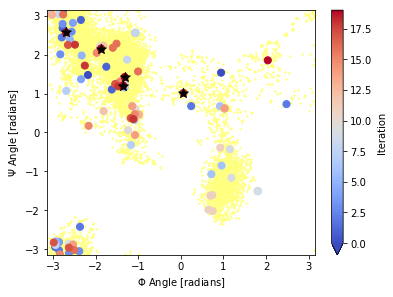

In [3]:
modnr=1
def plotSamplingDihedrals(nameData, nameFrontier, samplerAlgo, numberOfFrontierPoints, methodName,singleDataFrame=False, X_FT=None):
    
    psi_indices, phi_indices = [6, 8, 14, 16], [4, 6, 8, 14]
    top=md.Topology().from_openmm(samplerAlgo.model.testsystem.topology)
    
    if X_FT is None:
        X_FT = helpers.loadData(nameData, top, modnr)
    inp=md.Trajectory(X_FT, top)

    angles = md.geometry.compute_dihedrals(inp, [phi_indices, psi_indices]) 
    
    fig = plt.figure(figsize=(6,4.5))
    ax = fig.add_subplot(111)
    
    ax.scatter(angles[:, 0], angles[:, 1], s=2, c=[1,1,0.5]);
            
    X_frontier = helpers.loadData(nameFrontier, top, modnr)
    inpFrontierPoints = md.Trajectory(X_frontier, top)
    anglesFrontierPoints = md.geometry.compute_dihedrals(inpFrontierPoints, [phi_indices, psi_indices]) 
         
    nrIt = int(len(anglesFrontierPoints) / numberOfFrontierPoints)
    colfp = np.asarray(range(0,nrIt))
    cfp=list()
    for i in range(numberOfFrontierPoints):
        cfp.append(colfp)
    cfarr=(np.asarray(cfp).transpose())
    cfarr=cfarr.reshape(len(anglesFrontierPoints))
    print(cfarr)
    
    axfp = ax.scatter(anglesFrontierPoints[:, 0], anglesFrontierPoints[:, 1], s=50, c = cfarr, cmap ='coolwarm',vmin=0, vmax=cfarr.max());
    cbar = plt.colorbar(axfp,extend='min')
    cbar.set_label('Iteration')
    ax.scatter(anglesFrontierPoints[-(numberOfFrontierPoints)-1:-1, 0], anglesFrontierPoints[-(numberOfFrontierPoints)-1:-1, 1], s=100, c = 'k', marker = '*')
    
    
    #ax.set_title('Alanine dipeptide ')
    ax.set_xlabel(r'$\Phi$ Angle [radians]')
    plt.xlim(-np.pi, np.pi)
    ax.set_ylabel(r'$\Psi$ Angle [radians]')
    plt.ylim(-np.pi, np.pi)
    
    #plt.savefig(dataFolderName+'/corner_points.pdf',  format='pdf', dpi=1, bbox_inches='tight')
    #plt.savefig(dataFolderName+'/corner_points.png',  format='png', dpi=None, bbox_inches='tight')
    plt.show()
    
if methodName == 'local_frontier_points':
    numberOfFrontierPoints=1 #
else:
    numberOfFrontierPoints=5
plotSamplingDihedrals(dataFolderName+'/Traj/*.h5', dataFolderName+'/Traj/FrontierPoints/'+'*.h5',  smpl, numberOfFrontierPoints, methodName)

In [74]:
def compute_dihedrals_phi(X_FT):
    psi_indices, phi_indices = [6, 8, 14, 16], [4, 6, 8, 14]
    
    inp=md.Trajectory(X_FT, md.Topology().from_openmm(smpl.model.testsystem.topology))

    Y = md.geometry.compute_dihedrals(inp, [phi_indices, psi_indices]) 
    return Y[:,0]

def compute_dihedrals_psi(X_FT):
    psi_indices, phi_indices = [6, 8, 14, 16], [4, 6, 8, 14]
    
    inp=md.Trajectory(X_FT, md.Topology().from_openmm(smpl.model.testsystem.topology))

    Y = md.geometry.compute_dihedrals(inp, [phi_indices, psi_indices]) 
    return Y[:,1]

colective_variable = compute_dihedrals_phi
cv_name = 'Dihedral angle phi'




# Load trajectory here

Loaded trajectory of length 10000


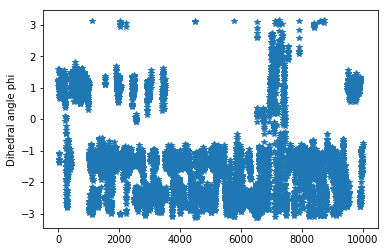

In [114]:
if metric_choice == 'rmsd':
    al = False
elif metric_choice == 'euclidean':
    al = False

modnr=1
X_FT = helpers.loadData(dataFolderName+'/Traj/*.h5', mdl.testsystem.topology, modnr, align=al)
print('Loaded trajectory of length '+repr(X_FT.shape[0]))

#compute collective variable
r=colective_variable(X_FT)
cv=r

plt.plot(range(len(r)), r, '*')
plt.ylabel(cv_name)
plt.savefig(simulationFolder+'/colvar.png')

plt.show()

In [115]:
def plotSamplingDihedrals_fromData(X_FT, topology, methodName=None, color=None, title=None):
    
    psi_indices, phi_indices = [6, 8, 14, 16], [4, 6, 8, 14]
    top=topology #md.Topology().from_openmm(samplerAlgo.model.testsystem.topology)
    
    inp=md.Trajectory(X_FT, top)

    angles = md.geometry.compute_dihedrals(inp, [phi_indices, psi_indices]) 
    
    fig = plt.figure(figsize=(6,4.5))
    ax = fig.add_subplot(111)
    
    if color is None:
        clr =[1,1,0.5]
    else:
        clr = color
    ax.scatter(angles[:, 0], angles[:, 1], s=2, c=clr);
    ax.set_title(title)
    ax.set_xlabel(r'$\Phi$ Angle [radians]')
    plt.xlim(-np.pi, np.pi)
    ax.set_ylabel(r'$\Psi$ Angle [radians]')
    plt.ylim(-np.pi, np.pi)
    plt.show()



In [116]:
import MDAnalysis as mda
from MDAnalysis.analysis import align
from MDAnalysis.analysis.rms import rmsd

trj = mda.Universe('/Users/zofia/github/DFM/alanine-ff96.pdb', X_FT) 
print(trj.trajectory)
ref = mda.Universe('/Users/zofia/github/DFM/alanine-ff96.pdb')#, X_FT[0,:,:]) 
alignment = align.AlignTraj(trj, trj)
alignment.run()
X_aligned = np.zeros(X_FT.shape)
ci=0
for ts in trj.trajectory:
    X_aligned[ci] = trj.trajectory.ts.positions
    ci=ci+1

print(X_aligned.shape)
print(alignment)
X_FT=X_aligned

<MemoryReader with 10000 frames of 22 atoms>
(10000, 22, 3)


In [117]:
def compute_free_energy(cv, weights=None, nrbins=100):


    pi_marginal, bin_edges = np.histogram(cv, bins = nrbins, weights = weights, density=True)
    bin_widths = bin_edges[1:] - bin_edges[:-1]
    bin_centers = bin_edges[:-1] + 0.5*bin_widths
    free_energy= - np.log(pi_marginal)

    return free_energy, bin_centers

#  Stein force

In [130]:
from sklearn.neighbors import NearestNeighbors

def compute_force(XL):
       
    force = []
    
    for n in range(len(XL)):
        force.append( smpl.model.force(XL[n]))

    return force

def compute_stein_force(XL, leader_set, model):
   
    force = []
    
    for n in range(len(XL)):
        force.append( smpl.model.force(XL[n]))
    # create numpy array from the list force which has also units    
    forcenp = []
    # remove units (we needed the units for the force call before!)
    for n in range(len(force)):
        forcenp.append(force[n].value_in_unit(model.force_unit))
    
    forcenp = np.asarray(forcenp)
    # create numpy array from the list XL which has also units
    
    XreshList = []
    # remove units (we needed the units for the force call before!)
    for n in range(len(XL)):
        XreshList.append(XL[n].value_in_unit(model.x_unit))
    
    Xresh = np.asarray(XreshList)
    # reshape for neighbor search steps x DOF
    Xresh = Xresh.reshape(Xresh.shape[0],Xresh.shape[1]*Xresh.shape[2])
    # choose leader particles using the index set leader_set
    X_leader = np.copy(Xresh[leader_set,:])
    
    
    # find neighbors
    kNeighb=50
    neigh = NearestNeighbors(metric='euclidean').fit(X_leader)
    dist, ind = neigh.kneighbors(X_leader, n_neighbors=5)
    
    # kernel scaling parameter
    h=1
    
    force_resh = forcenp.reshape(forcenp.shape[0],forcenp.shape[1]*forcenp.shape[2])
    force_mean = np.copy(force_resh)
    
    for n in range(len(leader_set)):#range(Xresh.shape[0]):#leader_set:#
        
        force_mean[leader_set[n]] = force_resh[leader_set[n]] 
        
        kij = np.exp(-dist[n]**2/h)
        force_mean[leader_set[n],:] = np.mean(kij*force_resh[ind[n]].transpose(), axis=1)
        force_mean[leader_set[n],:] += np.mean( kij * (X_leader[ind[n],:]-Xresh[n,:]).transpose(), axis=1)/h
        
    #print('force mean shape '+repr(force_mean.shape))
    force_SVGD = force_mean.reshape(forcenp.shape[0], forcenp.shape[1], forcenp.shape[2])
    #print('force SVGD shape '+repr(force_SVGD.shape))
    
    force_SVGDList = []
    for n in range(len(force)):
        force_SVGDList.append(force_SVGD[n]*model.force_unit)
    
    return force_SVGDList

# Iterate Stein

(1000, 22, 3)
(1000, 22, 3)


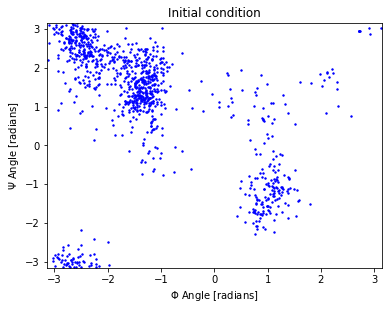

Stein iteration 0
Stein iteration 1
Stein iteration 2
Stein iteration 3
Stein iteration 4
Stein iteration 5
Stein iteration 6
Stein iteration 7
Stein iteration 8
Stein iteration 9


In [136]:
numberOfSteinSteps = 10

X_short = np.copy(X_FT[::10])
print(X_short.shape)
XL = []
[XL.append( X_short[n] * smpl.model.x_unit) for n in range(X_short.shape[0])]
print(X_short.shape)
p=np.random.randn(X_short.shape[0],X_short.shape[1],X_short.shape[2])
epsilon_step=unit.Quantity(1.0, unit.femtosecond)

# choose leader set
leader_set = np.random.choice(range(X_short.shape[0]), 500)#np.array(range(X_short.shape[0]))# 

## optionally for Langevin later
# gamma = 1.0# / unit.picosecond
# a = np.exp(-gamma * (eps_dt))
# b = np.sqrt(1 - np.exp(-2 * gamma * (eps_dt)))
kT = smpl.kT#.value_in_unit(smpl.model.energy_unit)
mass = smpl.model.masses #.value_in_unit(smpl.model.mass_unit)

q = np.copy(X_short)
## velocities for Langevin
#V=[np.random.randn(*XL[0].shape) * np.sqrt(kT / mass) for n in range(len(XL))]
#v = np.random.randn(*q.shape) * np.sqrt(kT / mass)


plotSamplingDihedrals_fromData(q, smpl.model.testsystem.topology, methodName=None, color='b', title = 'Initial condition')
f = compute_stein_force(XL,leader_set, smpl.model)
#f = compute_force(XL)


for ns in range(numberOfSteinSteps):
    print('Stein iteration '+repr(ns))
    f = compute_stein_force(XL,leader_set, smpl.model)
    #f = compute_force(XL)
    for n in range(len(XL)):
        XL[n] = (XL[n] + epsilon_step**2 * f[n] /mass );
        q[n,:,:] =  np.copy(XL[n].value_in_unit(smpl.model.x_unit))
        
#     print(XL[0]+epsilon_step**2 *f[0]/mass)
#     while(1):
#             pass
    
    # periodic boundary conditions?
    
    ## plot progress
    #plotSamplingDihedrals_fromData(q, smpl.model.testsystem.topology, methodName=None, color='b', title = 'Iteration '+repr(ns))
    if np.isnan(q).any():
        print('Explosion. Nan.')
        break

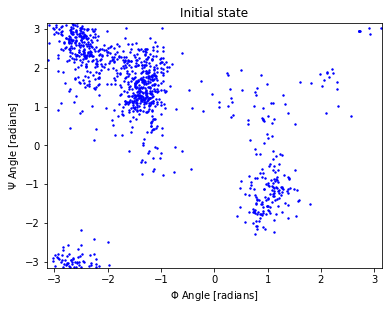

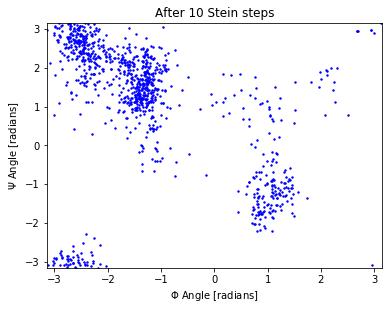

In [139]:

plotSamplingDihedrals_fromData(X_short, smpl.model.testsystem.topology, methodName=None, color='b', title='Initial state')
plotSamplingDihedrals_fromData(q, smpl.model.testsystem.topology, methodName=None, color='b', title='After '+repr(numberOfSteinSteps)+' Stein steps')


In [140]:
# debug
print((X_short==q).all())

False


# Compare free energies with reference

In [141]:
# load reference free energy profile at 300 K
reference_folder_300K='/Users/zofia/github/DFM/Results/Alanine/T300/'

FE_ref_phi = np.load(reference_folder_300K+ 'reference_alanine_300K_1fs_FE_phi.npy')
bc_ref_phi = np.load(reference_folder_300K+ 'reference_alanine_300K_1fs_bins_phi.npy')

FE_ref_psi = np.load(reference_folder_300K+ 'reference_alanine_300K_1fs_FE.npy')
bc_ref_psi = np.load(reference_folder_300K+ 'reference_alanine_300K_1fs_bins.npy')

Computing collective variable of trajetory of  1000 points


/Users/zofia/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


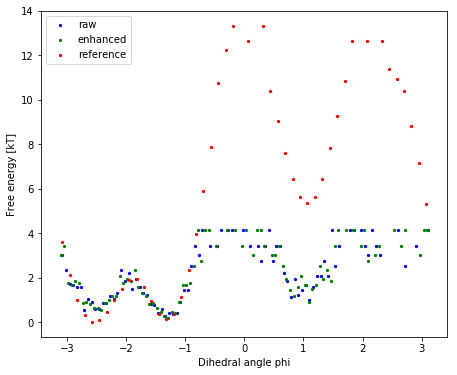

In [142]:
nrBins=100

print('Computing collective variable of trajetory of  '+repr(len(X_short))+' points')
cv=compute_dihedrals_phi(X_short)
cv_stein=compute_dihedrals_phi(q)

free_energy_raw_phi, bin_centers_raw_phi = compute_free_energy(cv, nrbins = nrBins)
free_energy_SteinIS_phi, bin_centers_SteinIS_phi = compute_free_energy(cv_stein, nrbins = nrBins)

fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(121)
ax.scatter(bin_centers_raw_phi, free_energy_raw_phi, s=5, c='b', marker='o')
ax.scatter(bin_centers_SteinIS_phi, free_energy_SteinIS_phi, s=5, c='g', marker='o')
ax.scatter(bc_ref_phi, FE_ref_phi, s=5, c='r', marker='o')
plt.legend(['raw', 'enhanced', 'reference'])
ax.set_xlabel('Dihedral angle phi')
ax.set_ylabel('Free energy [kT]')

plt.show()
